In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'HumanDevelopingBrain'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/HumanDevelopingBrain/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/HumanDevelopingBrain/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 17336 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [5]:
adata

AnnData object with n_obs × n_vars = 9443 × 3000
    obs: 'Age', 'Code of spatial sample', 'Condition', 'DoubletScore', 'ExperimentDate', 'Parent_sample_ID', 'Patient no', 'PredictedDoublets', 'Replicate_ID', 'Sample_ID', 'Sanger_sample_ID', 'Sex', 'Size', 'Spatial info', 'Target_no_cells', 'batch', 'n_genes', 'sample_id_useful1', 'sample_id_useful2', 'sample_id_useful3', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'sample_id_useful3_colors'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [6]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


2023-07-21 13:31:03.565091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-21 13:31:03.565273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-21 13:31:03.565296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Number of Leiden Clusters: 10
Maximal Number of Modules: 11


Overview of the dataset on a UMAP, coloured by cluster assingment.

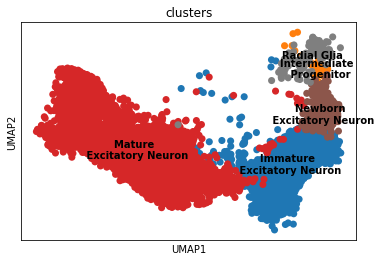

In [7]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [8]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                           batch_key = 'Sanger_sample_ID')

... and initialize the model:

In [9]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules)

Let's have a look at the anndata setup:

In [10]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sanger_sample_ID',
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 9443  │
│      n_vars      │ 3000  │
│     n_batch      │   2   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                         batch State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sanger_sample_ID'] │ AA_DOW8726785 │          0          │
│                               │ AA_DOW8726786 │          1          │
└───────────────────────────────┴───────────────┴─────────────────────┘

Training the model:

In [11]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [21:40<00:00,  2.60s/it, v_num=1, elbo_train=2.53e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

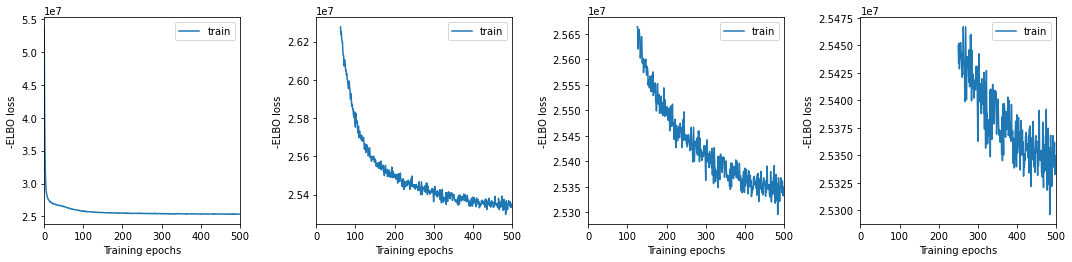

In [12]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [13]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 9443
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

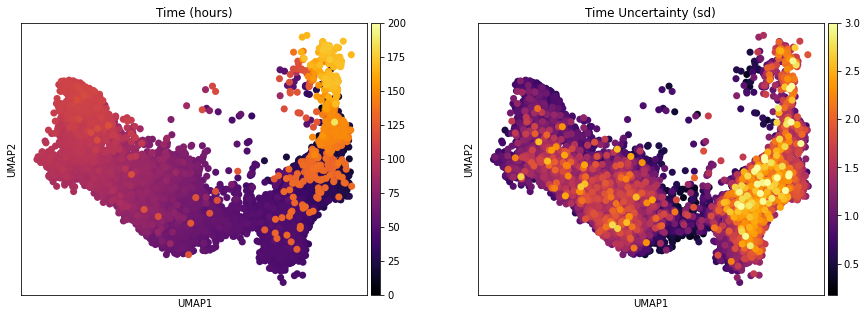

In [14]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0], vmin = 0, vmax = 200)
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1], vmax = 3)
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

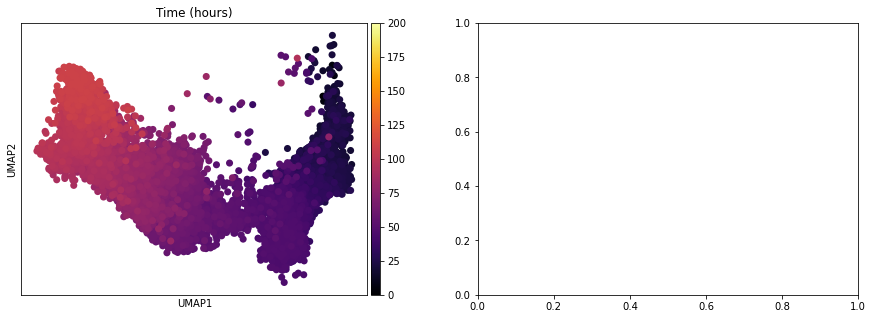

In [15]:
adata_subset = adata[adata.obs['Time (hours)'] < 110]
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata_subset, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0], vmin = 0, vmax = 200)
plt.savefig(results_path + data_name + 'UMAP_Time2.pdf')

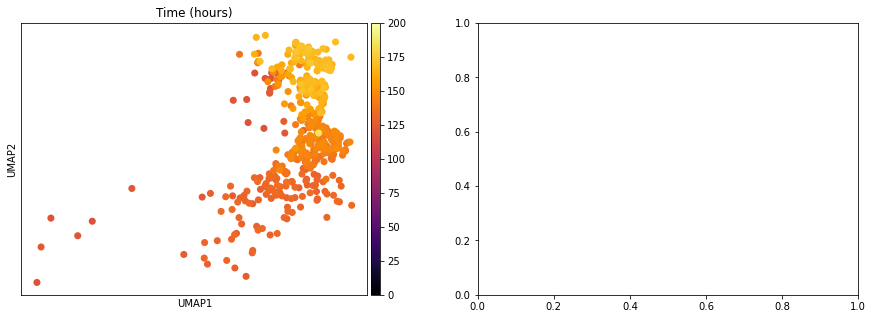

In [16]:
adata_subset = adata[adata.obs['Time (hours)'] > 120]
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata_subset, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0], vmin = 0, vmax = 200)
plt.savefig(results_path + data_name + 'UMAP_Time3.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

In [17]:
adata = mod.compute_module_summary_statistics(adata)

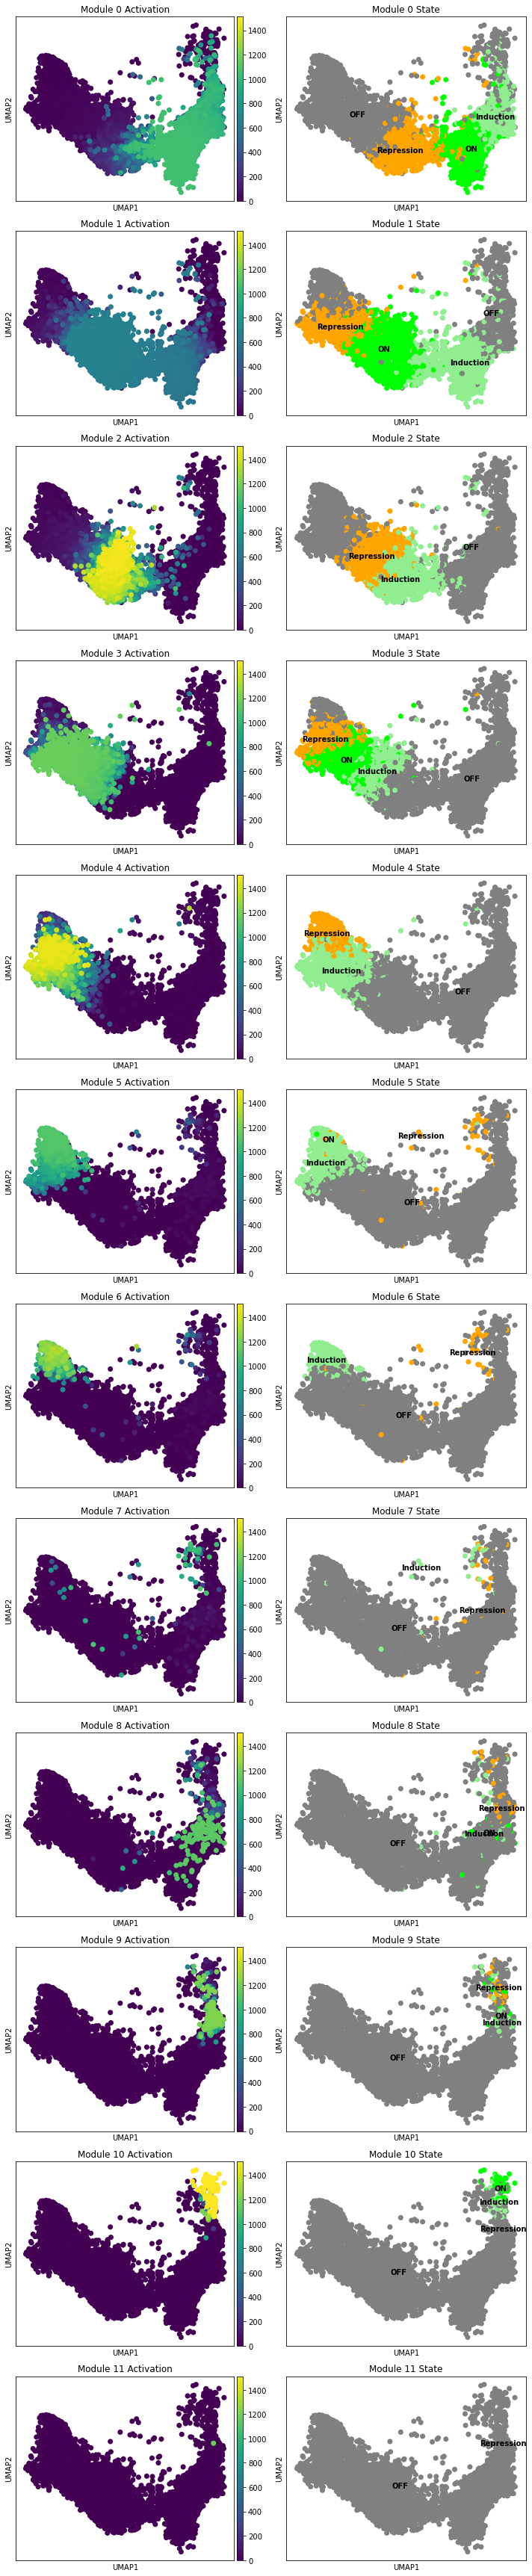

In [18]:
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

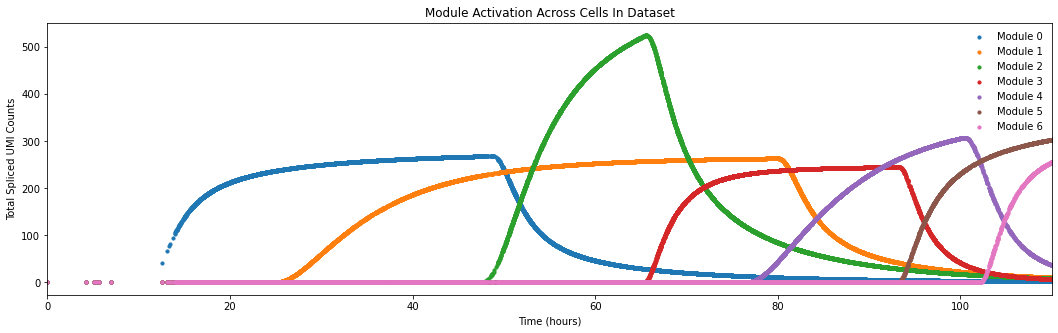

In [19]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5,6], time_max = 110, time_min = 0,
                         save = results_path + data_name + 'module_activation_comparison.pdf')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


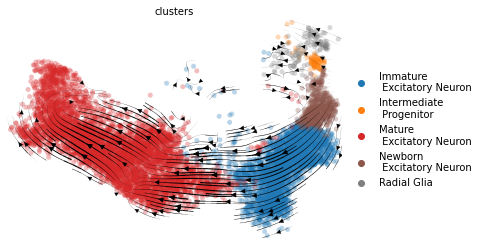

In [20]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

To make the plot look the same in style as the scvleo plots:

In [21]:
adata.obs['clusters'] = adata.obs['clusters'].astype(str)
adata.obs['clusters'].loc[adata.obs['clusters'] == 'Intermediate \n Progenitor'] = 'Intermediate Progenitor'

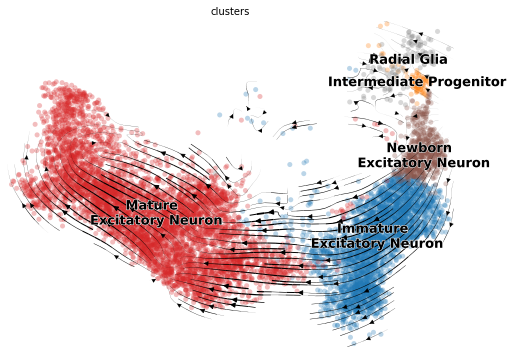

In [22]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

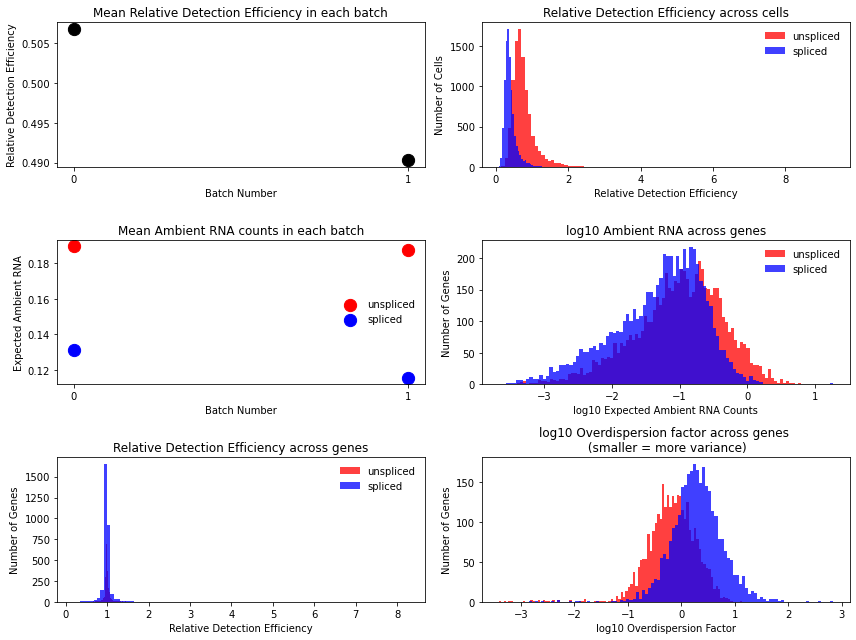

In [23]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [24]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.12515676
gamma_g mean: 1.2365018
beta_g mean: 0.7251778
lam_mi, all modules: 
 
 [[[3.99 1.59]]

 [[0.17 1.55]]

 [[0.43 1.89]]

 [[3.28 3.73]]

 [[0.12 1.  ]]

 [[3.93 1.51]]

 [[3.21 2.05]]

 [[2.6  2.35]]

 [[4.11 6.27]]

 [[4.59 1.53]]

 [[3.16 2.97]]

 [[3.02 2.37]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [25]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.05, species = 'Human', background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')
tab

Module Number                                       Genes Ranked  \
0               0  PTPRT, FAM19A1, RSPO3, NEFM, INHBA, PTPRK, KRE...   
1               1  RP11-648L3.2, PA2G4, RWDD1, BROX, HELQ, PSMC3,...   
2               2  IL33, CTC-498M16.2, OSTN, ST8SIA1, KRR1, ERI2,...   
3               3  RP11-541F9.2, FAM153C, WLS, COL16A1, CADPS2, C...   
4               4  PIEZO2, CA10, CDH18, ADAMTS17, BMPER, COLEC12,...   
5               5  SYNPR, COL19A1, PIK3C2G, BARD1, RP11-734K2.4, ...   
6               6  COL24A1, SGCZ, VWC2, LHFPL3, MARCH11, LIN28B, ...   
7               7  ID4, RP11-544A12.8, Z83001.1, NPAS3, TMEM132D,...   
8               8  DLX6-AS1, DBT, ZNF786, ZNF397, RP11-418J17.1, ...   
9               9  ERBB4, PAG1, CTDSP2, PPP1R17, ULK1, GPR39, TCA...   
10             10  BRIP1, E2F2, POLQ, C2orf48, MCM10, DIAPH3, KIF...   
11             11  LIPE, PXN, NXPH1, ZNF397, FBXO7, ERBB4, MOSPD2...   

                                           TFs Ranked  \
0   BCL6, SATB2, CUX2, ZNF608, MSANTD4, GTF2IRD2, ...   
1   PA2G4, ZNF791, ZNF354A, DNTTIP1, CDC5L, ZNF429...   
2   ZNF26, ETV1, MYB, ZNF480, ZNF33A, ZNF189, SKIL...   
3   FOXP2, ZFPM2, HMGA2, SETDB2, ZFHX3, NPAS2, TBR...   
4   MBD2, ZNF12, PRR12, TRPS1, GTF2IRD1, MLXIP, RB...   
5   NR4A2, THAP6, ZNF345, HIF3A, SMAD9, CARF, BAZ2...   
6   LIN28B, IKZF2, ZNF397, ZNF264, ZNF76, ZEB1, ZN...   
7   NPAS3, SOX6, RFX4, DACH1, TCF7L2, ARX, ZNF536,...   
8   ZNF786, ZNF397, RFX4, SMAD1, FOXO3, ZNF570, ZN...   
9   ZNF260, ZNF189, ZEB1, FOXP4, ZNF536, ZNF844, B...   
10  E2F2, SOX6, DACH1, GLI3, TFAP2C, ARX, EOMES, Z...   
11  ZNF397, ZNF785, ZNF433, ZNF136, ZNF891, ZNF570...   

                                         Terms Ranked  
0                                                      
1   ribosomal large subunit biogenesis (GO:0042273...  
2   cotranslational protein targeting to membrane ...  
3   G protein-coupled glutamate receptor signaling...  
4   cellular response to organic cyclic compound (...  
5                      neuron projection (GO:0043005)  
6                                                      
7   DNA metabolic process (GO:0006259), double-str...  
8                   mitochondrial matrix (GO:0005759)  
9                                                      
10  DNA metabolic process (GO:0006259), mitotic sp...  
11

Reprocessing adata.X, set process = False if this is not desired.


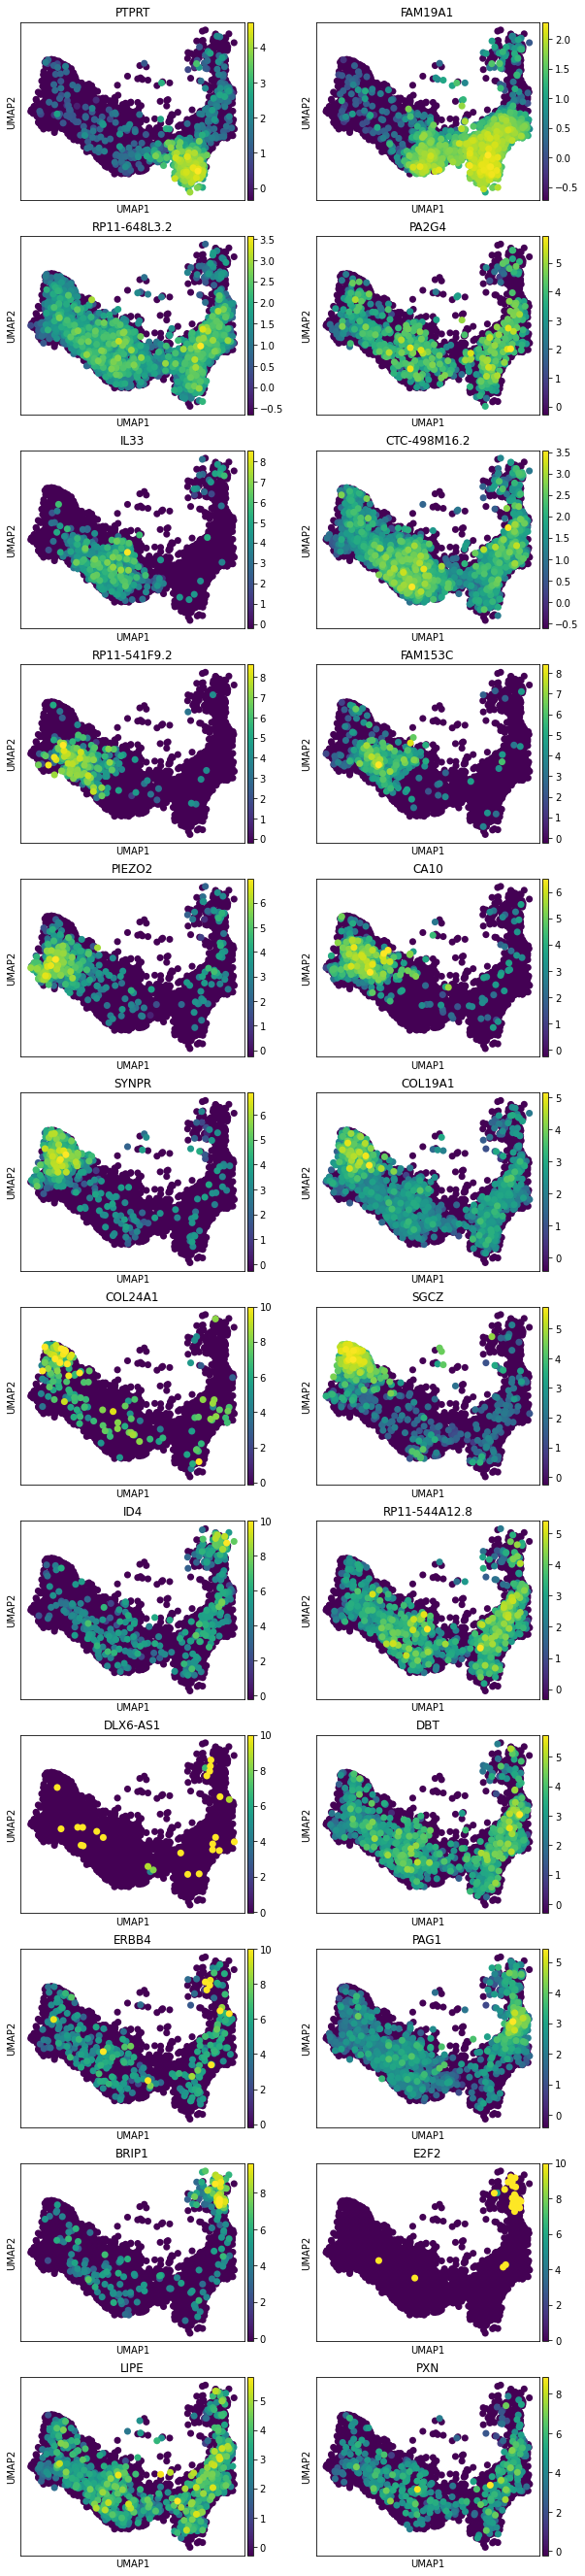

In [26]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,3,4,5,6,7,8,9,10,11], mode = 'all genes',
                      n_top_features = 2, process = True,
                      save = results_path + data_name + 'top_2_gene_allModules_plot.png')

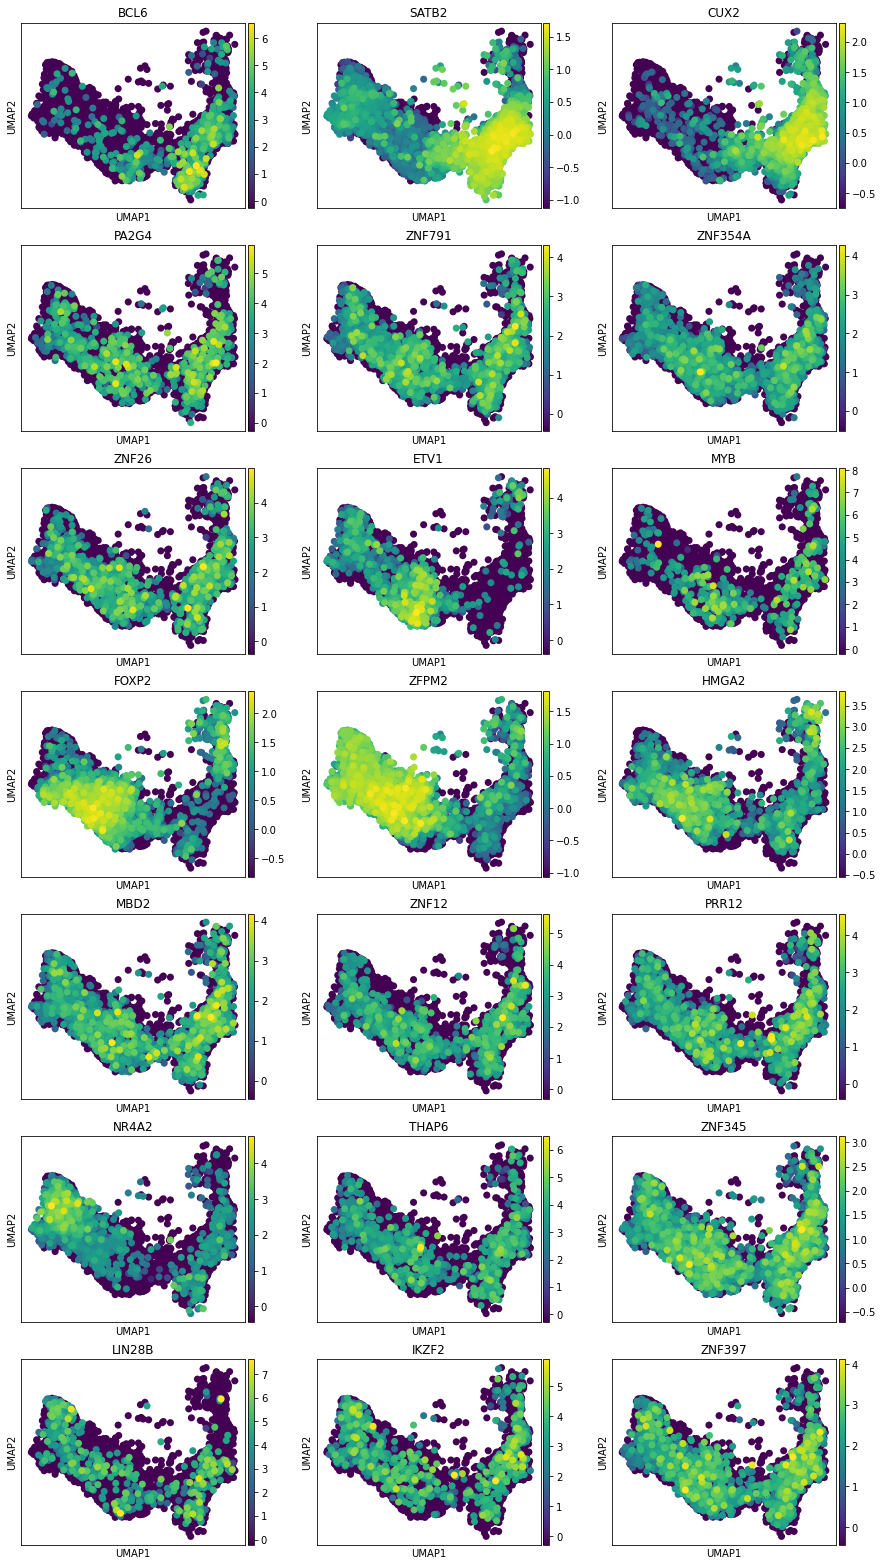

In [27]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,3,4,5,6], mode = 'TFs',
                      n_top_features = 3, process = False,
                      save = results_path + data_name + 'top_TFs_plot_1to7.pdf')

We save the steady-state gene expression of each module for later use with cell2location:

In [28]:
import pandas as pd
pd.DataFrame(mod.samples['post_sample_means']['g_fg'].T,
             columns = np.array(['Module ' + str(m) for m in range(n_modules)]),
             index = adata.var_names).to_csv(results_path + data_name + 'modules.csv')

Show expression of neuron layer marker genes:

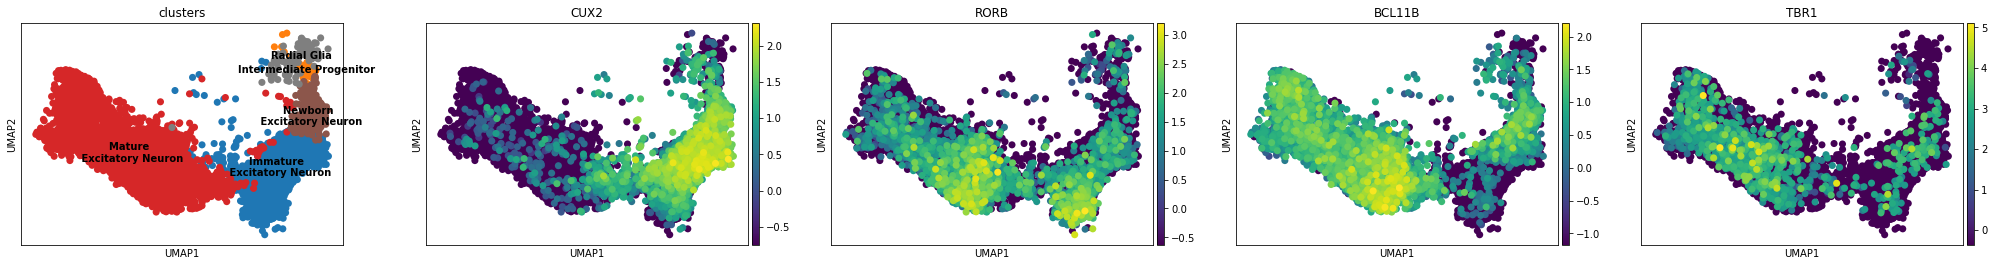

In [29]:
sc.pl.umap(adata, color = ['clusters', 'CUX2', 'RORB', 'BCL11B', 'TBR1'], s = 200, legend_loc='on data', show = True, ncols = 5, save = False)

Visualize top module genes in a heatmap over time:

In [30]:
from matplotlib import gridspec

def plot_markers_vs_time(mod, adata, chosen_modules, top_genes, time_min = None, time_max = None):

    adata.X = adata.layers['unspliced'] + adata.layers['spliced']
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    
    if time_max:
        adata_subset = adata[adata.obs['Time (hours)'] < time_max]
    if time_min:
        adata_subset = adata[adata.obs['Time (hours)'] > time_min]
    adata_subset = adata_subset[np.argsort(adata_subset.obs['Time (hours)']),:]

    adata_subset.var['Module Marker'] = 'No'
    adata_subset.var['Module Marker'] = adata_subset.var['Module Marker'].astype(str)
    for m in chosen_modules:
        subset = [g in tab.loc[m, 'Genes Ranked'].split(', ')[:top_genes] for g in adata.var_names]
        adata_subset.var['Module Marker'][subset] = str(m)

    adata_subset = adata_subset[adata_subset.obs['clusters'] != 'Radial Glia',:]
    adata_subset = adata_subset[adata_subset.obs['clusters'] != 'Intermediate Progenitor',:]

    markers = []
    for m in chosen_modules:
        markers += list(adata_subset.var_names[adata_subset.var['Module Marker'] == str(m)])
    var_names = markers
    subset = [np.where(adata_subset.var_names == m)[0][0] for m in markers]
    obs_tidy = adata_subset.X[:,subset].T
    obs_tidy2 = np.sum(mod.samples['post_sample_means']['mu_expression'], axis = -1)
    time = mod.samples['post_sample_means']['T_c'][:,0,0]
    obs_tidy2 = obs_tidy2[np.argsort(time),:]
    time = time[np.argsort(time)]
    obs_tidy2 = obs_tidy2[time < 110,:]
    obs_tidy = obs_tidy2[:,subset].T
    obs_tidy = obs_tidy/np.expand_dims(np.max(obs_tidy, axis = 1), axis = -1)

    width = 10
    height = 10
    fig = plt.figure(figsize=(width, height))

    dendro_width = 0
    groupby_width = 0
    heatmap_width = 8
    colorbar_width = 0.2

    width_ratios = [
        groupby_width,
        heatmap_width,
        dendro_width,
        colorbar_width,
    ]

    height = 6
    height_ratios = [0, height]

    axs = gridspec.GridSpec(
        nrows=2,
        ncols=4,
        width_ratios=width_ratios,
        wspace=0.15 / width,
        hspace=0.13 / height,
        height_ratios=height_ratios,
    )

    heatmap_ax = fig.add_subplot(axs[1, 1])
    im = heatmap_ax.imshow(obs_tidy, aspect='auto', cmap='jet')
    heatmap_ax.set_ylim(obs_tidy.shape[0] - 0.5, -0.5)
    heatmap_ax.set_xlim(-0.5, obs_tidy.shape[1] - 0.5)
    heatmap_ax.tick_params(axis='y', left=False, labelleft=False)
    heatmap_ax.set_ylabel('')
    heatmap_ax.grid(False)

    groupby_ax = fig.add_subplot(axs[0, 1])
    groupby_ax.tick_params(axis='both', labelright = False, right = False, left=False, labelleft=False)
    groupby_ax.get_xaxis().set_ticks([])

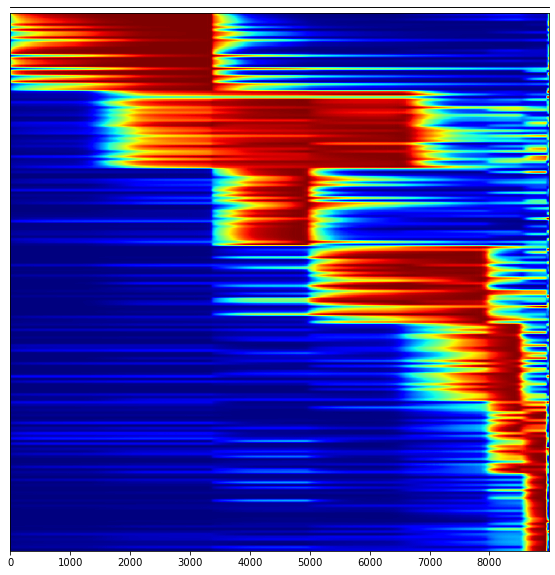

In [31]:
chosen_modules = [0,1,2,3,4,5,6]
top_genes = 30
plot_markers_vs_time(mod, adata, chosen_modules, top_genes, time_max = 110)